### Telco Customer Churn Analysis

In [313]:
import pandas as pd
from typing import List, Union
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score


In [298]:
df = pd.read_csv("./data.xls")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [300]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df = df.drop(columns=["customerID"], axis=1)

In [301]:
df.isna().sum()


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df.fillna(0, inplace=True)


_We don't have any missing values in the dataset, so we can proceed with the analysis._

_Now we will encode the categorical variables using Label Encoding._


In [303]:
le = LabelEncoder()

# Ecoding categorical columns using Label Encoding
def encode_categorical_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for col in columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

categorical_column = df.select_dtypes(include="object").columns.tolist()

df = encode_categorical_columns(df, categorical_column)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [304]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,64.761692,2279.734304,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,398.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1394.550000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


In [305]:

def outlier_detection_iqr(df: pd.DataFrame, column: List[str], threshold: float = 1.5) -> pd.DataFrame:
    """
    Detect outliers using the IQR method.
    """
    for col in column:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = outlier_detection_iqr(df, ['tenure', 'MonthlyCharges', 'TotalCharges'])


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


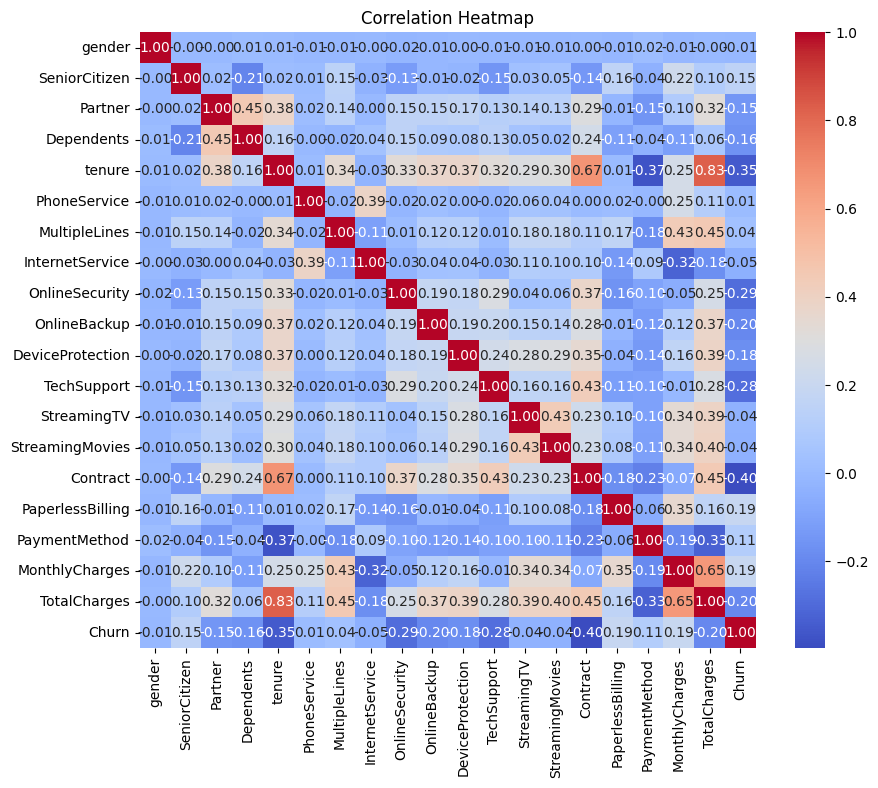

In [307]:
def correlation_heatmap(df: pd.DataFrame, figsize: Union[tuple, None] = (10, 8)) -> None:
    """
    Plot a correlation heatmap for the DataFrame.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap')
    plt.show()

correlation_heatmap(df.select_dtypes(include=['float64', 'int64']))



Correlation Analysis.


_We see that the `Contract` , `tenure` , `OnlineSecurity`, and `TechSupport` have a strong correlation with the target variable 'Churn'._

In [308]:
df.select_dtypes(include=['float64', 'int64']).corr()['Churn'].sort_values(ascending=False)

Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
InternetService    -0.047291
Partner            -0.150448
Dependents         -0.164221
DeviceProtection   -0.178134
OnlineBackup       -0.195525
TotalCharges       -0.198324
TechSupport        -0.282492
OnlineSecurity     -0.289309
tenure             -0.352229
Contract           -0.396713
Name: Churn, dtype: float64

In [309]:
def splitData(df: pd.DataFrame, target: str, test_size: float = 0.2, random_state: int = 42) -> tuple:
    """
    Split the DataFrame into training and testing sets.
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(df, target='Churn')

In [310]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_models(models: dict, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Evaluate multiple models and print their classification reports and accuracy scores.
    """
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        print(f"Model: {name}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("-" + "-" * 50)

evaluate_models(models, X_train, y_train, X_test, y_test)

Training Logistic Regression...
Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1036
           1       0.66      0.58      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.81      1409

Confusion Matrix:
[[925 111]
 [156 217]]
---------------------------------------------------
Training Random Forest...


/home/sahildev/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.47      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
[[944  92]
 [197 176]]
---------------------------------------------------
Training XGBoost...
Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.62      0.52      0.57       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
[[920 116]
 [180 193]]
---------------------------------------------------


/home/sahildev/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:50:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


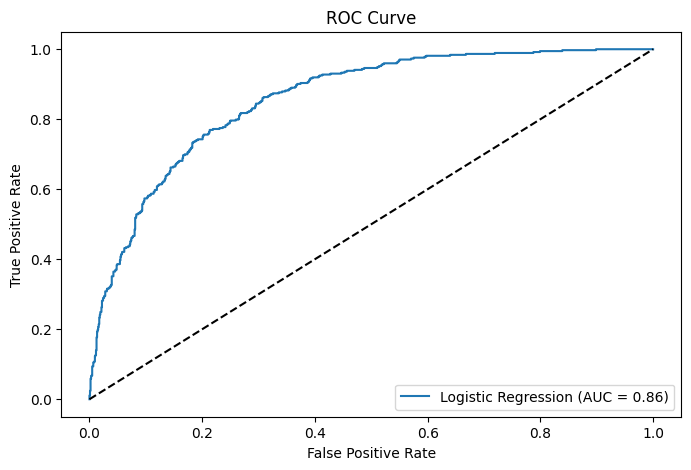

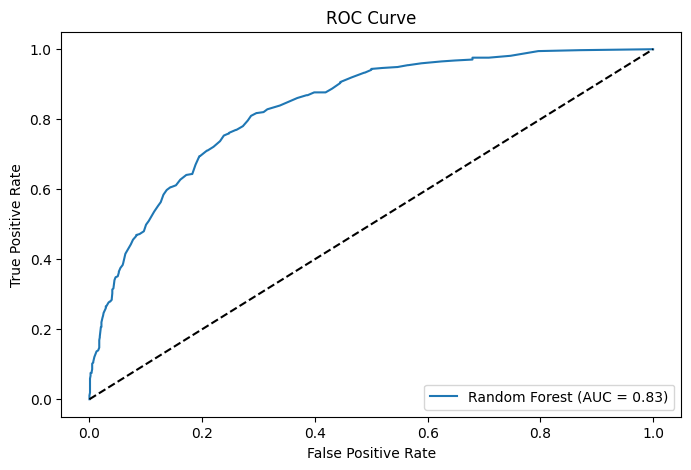

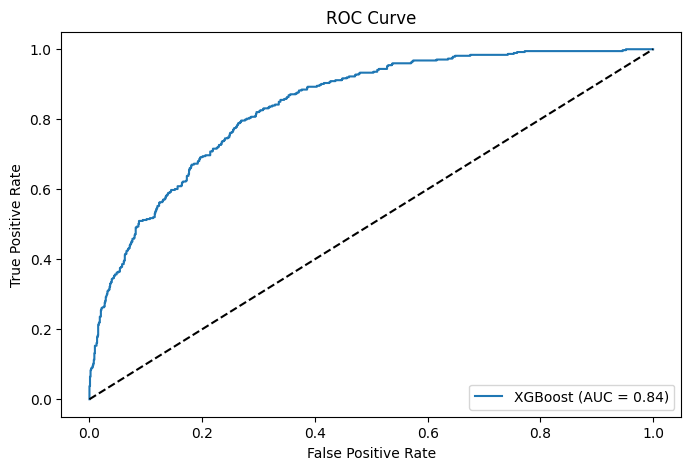

In [315]:
def plot_roc(model, X_test, y_test, model_name="Model"):
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


for name, model in models.items():
    plot_roc(model, X_test, y_test, model_name=name) 
